In [1]:
%matplotlib widget
# %matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pyobs
import bison

%load_ext autoreload
%autoreload 1

%aimport GEVP_pyobs

# plt.rcParams.update({
#     "text.usetex"      : True,
#     "font.family"      : "Helvetica",
#     "mathtext.fontset" : "dejavuserif"
# })
plt.rcParams.update({
    "axes.axisbelow"   : True,
})

In [2]:
### Loading data file ###
data = bison.load("Cnfgs_measurement/WF-slices_beta617_lat32x64.dat")

[Bison] : Reading file Cnfgs_measurement/WF-slices_beta617_lat32x64.dat
[Bison] : File created by gmorandi at ampere on Tue Dec 19 00:02:04 2023
[Bison] : Read 283.844 MB at 535.839 MB/s


In [3]:
##############################
### General run parameters ###
##############################
beta      =  data['beta coupling']
L1, L2, L3, T = data['Lattice']
V         =  L1 * L2 * L3 * T
D         =  4
Ns        =  data['Number of steps of OMF4 integrator']
tauMD     =  data['Length of each MD trajectory']
Ntraj     =  data['MD trajectories']
MC_step   =  data['MC measure step']
eps_WF    =  data['epsilon WF']
WF_evol   =  data['WF evolutions from t = 0']
WF_step   =  data['WF measure step']
Nwf       =  WF_evol // WF_step + 1
Nc_run    = Ntraj // MC_step

Ncnfg0 = 0
Nh     = 0
for key in data:
    if key.startswith('Configuration'):
        Ncnfg0 += 1
    if key.startswith('MC History'):
        Nh += 1


print(f"\n Lattice                =  [{L1}x{L2}x{L3}x{T}]")
print(f" Lattice volume         =  {V}")
print(f" beta                   =  {beta}")
print(f" Steps of OMF4          =  {Ns}")
print(f" tau MD                 =  {tauMD}")
print(f" MD trajectories        =  {Ntraj}")
print(f" MC interval between measurements  =  {MC_step}")
print(f" epsilon of Wilson Flow =  {eps_WF}")
print(f" Wilson Flow evolutions =  {WF_evol}")
print(f" Wilson Flow steps between measurements =  {WF_step}\n")

print(f" Measured flow times:")
print(f" from t = {eps_WF * WF_step * 0:.2f} to t = {eps_WF * WF_step * (Nwf - 1):.2f}")
print(f" total measurements in flow time = {Nwf}")

if T == 64:
    Ntherm0 = 200
    max_tau = 20
elif T == 256:
    Ntherm0 = 600
    max_tau = Ntherm0 // (5 * MC_step)            # CHANGE THIS DEPENDING ON THE NEW TAU.      

print(f"\n Total number of measurements = {Ncnfg0}, extracted from {Nh} runs, {Nc_run} meas. each.")
print(f" Total number of configurations = {int(Ncnfg0 * tauMD * MC_step)} MDU")
print(f" Preliminary thermalization trajectories = {Ntherm0}, i.e. {int(Ntherm0 * tauMD)} MDU")
print(f" we should reach 5 x max(tau_int) [MDU], namely ~ {int(5 * MC_step * tauMD * max_tau)} MDU")
print(f" so we skip {(5 * max_tau * MC_step - Ntherm0)*int(tauMD)} MDUs in the current initial data.\n")
skip = (5 * max_tau * MC_step - Ntherm0) // MC_step
print(f" In other words we have to skip {skip} measurements.")

Ncnfg = Ncnfg0 - skip

print(f" Total configs. = {Ncnfg} (after removing initial due to therm.)")


 Lattice                =  [32x32x32x64]
 Lattice volume         =  2097152
 beta                   =  6.17
 Steps of OMF4          =  8
 tau MD                 =  2.0
 MD trajectories        =  200
 MC interval between measurements  =  10
 epsilon of Wilson Flow =  0.02
 Wilson Flow evolutions =  300
 Wilson Flow steps between measurements =  5

 Measured flow times:
 from t = 0.00 to t = 6.00
 total measurements in flow time = 61

 Total number of measurements = 3160, extracted from 158 runs, 20 meas. each.
 Total number of configurations = 63200 MDU
 Preliminary thermalization trajectories = 200, i.e. 400 MDU
 we should reach 5 x max(tau_int) [MDU], namely ~ 2000 MDU
 so we skip 1600 MDUs in the current initial data.

 In other words we have to skip 80 measurements.
 Total configs. = 3080 (after removing initial due to therm.)


In [4]:
########################################################
### Loading history run and observables measurements ###
########################################################
WF_EClov = np.zeros((Ncnfg0, Nwf, T))
WF_Plaq  = np.zeros((Ncnfg0, Nwf, T))
WF_Q     = np.zeros((Ncnfg0, Nwf, T))

for i in range(Ncnfg0):
    WF_EClov[i,:,:] = data[f'Configuration {i+1}']['E_Clov']
    WF_Plaq[i,:,:]  = data[f'Configuration {i+1}']['Plaquette']
    WF_Q[i,:,:]     = data[f'Configuration {i+1}']['Q']

t_WF  = np.array([eps_WF * WF_step * i for i in range(Nwf)])
t_min = np.ceil(np.sqrt(8*t_WF)).astype('int32')
print(f"Wilson flow times  :\n{t_WF}\n")
print(f"Corresponding minimum physical distances, i.e. ~ int(sqrt(8 t_WF))  :\n{t_min}")

Wilson flow times  :
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6. ]

Corresponding minimum physical distances, i.e. ~ int(sqrt(8 t_WF))  :
[0 1 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


In [6]:
###############################################################
### Compute <E(t)>_Clov for 0 <= t <= T-1 and for each t_WF ###
EClov_t = []
EClov   = []  
for i0 in range(Nwf):
    EClov_t.append(pyobs.observable(description=f'<E(t)> Clov at t_WF = {t_WF[i0]:.2f}'))
    EClov_t[-1].create('Ensemble A', (WF_EClov[skip:,i0,:] * T/V).flatten(), shape=(T,))
    EClov.append(pyobs.sum(EClov_t[-1]) / T)
    print(f"(t_WF = {t_WF[i0]:.2f}) :    <E>_Clov = {EClov[-1]}")
    # print(f"(t_WF = {t_WF[i0]:.2f}) :    <E(t)>_Clov = {EClov_t[-1]}                      <E>_Clov = {EClov[-1]}")
###############################################################

(t_WF = 0.00) :    <E>_Clov = 1.955315(10)

(t_WF = 0.10) :    <E>_Clov = 1.373091(15)

(t_WF = 0.20) :    <E>_Clov = 0.859931(17)

(t_WF = 0.30) :    <E>_Clov = 0.548212(17)

(t_WF = 0.40) :    <E>_Clov = 0.371000(17)

(t_WF = 0.50) :    <E>_Clov = 0.266804(16)

(t_WF = 0.60) :    <E>_Clov = 0.201888(16)

(t_WF = 0.70) :    <E>_Clov = 0.159063(16)

(t_WF = 0.80) :    <E>_Clov = 0.129373(16)

(t_WF = 0.90) :    <E>_Clov = 0.107917(15)

(t_WF = 1.00) :    <E>_Clov = 0.091872(15)

(t_WF = 1.10) :    <E>_Clov = 0.079528(15)

(t_WF = 1.20) :    <E>_Clov = 0.069804(15)

(t_WF = 1.30) :    <E>_Clov = 0.061990(15)

(t_WF = 1.40) :    <E>_Clov = 0.055601(15)

(t_WF = 1.50) :    <E>_Clov = 0.050302(15)

(t_WF = 1.60) :    <E>_Clov = 0.045848(15)

(t_WF = 1.70) :    <E>_Clov = 0.042064(15)

(t_WF = 1.80) :    <E>_Clov = 0.038817(15)

(t_WF = 1.90) :    <E>_Clov = 0.036005(15)

(t_WF = 2.00) :    <E>_Clov = 0.033551(14)

(t_WF = 2.10) :    <E>_Clov = 0.031394(14)

(t_WF = 2.20) :    <E>_Clov = 0.

In [7]:
#############################################################
### Compute <Plaq(t)> for 0 <= t <= T-1 and for each t_WF ###
Plaq_t = []
Plaq   = []
for i0 in range(Nwf):
    Plaq_t.append(pyobs.observable(description=f'<Plaq(t)> at t_WF = {t_WF[i0]:.2f}'))
    Plaq_t[-1].create('Ensemble A', (WF_Plaq[skip:,i0,:] * T/V).flatten(), shape=(T,))
    Plaq.append(pyobs.sum(Plaq_t[-1]) / T)
    print(f"(t_WF = {t_WF[i0]:.2f}) :    <Plaq> = {Plaq[-1]}")
    # print(f"(t_WF = {t_WF[i0]:.2f}) :    <Plaq(t))> = {Plaq_t[-1]}                       <Plaq> = {Plaq[-1]}")
#############################################################

(t_WF = 0.00) :    <Plaq> = 0.6108656(16)

(t_WF = 0.10) :    <Plaq> = 0.8364665(13)

(t_WF = 0.20) :    <Plaq> = 0.92922921(99)

(t_WF = 0.30) :    <Plaq> = 0.96542871(79)

(t_WF = 0.40) :    <Plaq> = 0.98072051(67)

(t_WF = 0.50) :    <Plaq> = 0.98793502(60)

(t_WF = 0.60) :    <Plaq> = 0.99172994(56)

(t_WF = 0.70) :    <Plaq> = 0.99392718(53)

(t_WF = 0.80) :    <Plaq> = 0.99530557(51)

(t_WF = 0.90) :    <Plaq> = 0.99622836(50)

(t_WF = 1.00) :    <Plaq> = 0.99687914(49)

(t_WF = 1.10) :    <Plaq> = 0.99735755(48)

(t_WF = 1.20) :    <Plaq> = 0.99772118(47)

(t_WF = 1.30) :    <Plaq> = 0.99800516(46)

(t_WF = 1.40) :    <Plaq> = 0.99823195(46)

(t_WF = 1.50) :    <Plaq> = 0.99841649(46)

(t_WF = 1.60) :    <Plaq> = 0.99856903(45)

(t_WF = 1.70) :    <Plaq> = 0.99869686(45)

(t_WF = 1.80) :    <Plaq> = 0.99880525(44)

(t_WF = 1.90) :    <Plaq> = 0.99889811(44)

(t_WF = 2.00) :    <Plaq> = 0.99897840(43)

(t_WF = 2.10) :    <Plaq> = 0.99904839(43)

(t_WF = 2.20) :    <Plaq> = 0.9991

In [8]:
##########################################################
### Compute <q(t)> for 0 <= t <= T-1 and for each t_WF ###
Q_t = []
Q   = []
for i0 in range(Nwf):
    Q_t.append(pyobs.observable(description=f'<q(t)> at t_WF = {t_WF[i0]:.2f}'))
    Q_t[-1].create('Ensemble A', (WF_Q[skip:,i0,:] * T/V).flatten(), shape=(T,)) 
    Q.append(pyobs.sum(Q_t[-1]) / T)
    print(f"(t_WF = {t_WF[i0]:.2f}) :    <Q> = {Q[-1]}")
    # print(f"(t_WF = {t_WF[i0]:.2f}) :    <q(t)> = {Q_t[-1]}                      <Q> = {Q[-1]}")
##########################################################

(t_WF = 0.00) :    <Q> = -0.13(14)

(t_WF = 0.10) :    <Q> = -0.06(28)

(t_WF = 0.20) :    <Q> = 0.01(47)

(t_WF = 0.30) :    <Q> = 0.05(58)

(t_WF = 0.40) :    <Q> = 0.06(64)

(t_WF = 0.50) :    <Q> = 0.06(68)

(t_WF = 0.60) :    <Q> = 0.06(71)

(t_WF = 0.70) :    <Q> = 0.06(72)

(t_WF = 0.80) :    <Q> = 0.06(74)

(t_WF = 0.90) :    <Q> = 0.06(75)

(t_WF = 1.00) :    <Q> = 0.06(76)

(t_WF = 1.10) :    <Q> = 0.06(76)

(t_WF = 1.20) :    <Q> = 0.06(77)

(t_WF = 1.30) :    <Q> = 0.06(78)

(t_WF = 1.40) :    <Q> = 0.06(78)

(t_WF = 1.50) :    <Q> = 0.06(78)

(t_WF = 1.60) :    <Q> = 0.06(79)

(t_WF = 1.70) :    <Q> = 0.06(79)

(t_WF = 1.80) :    <Q> = 0.06(79)

(t_WF = 1.90) :    <Q> = 0.06(80)

(t_WF = 2.00) :    <Q> = 0.06(80)

(t_WF = 2.10) :    <Q> = 0.06(80)

(t_WF = 2.20) :    <Q> = 0.05(80)

(t_WF = 2.30) :    <Q> = 0.05(80)

(t_WF = 2.40) :    <Q> = 0.05(80)

(t_WF = 2.50) :    <Q> = 0.05(81)

(t_WF = 2.60) :    <Q> = 0.05(81)

(t_WF = 2.70) :    <Q> = 0.05(81)

(t_WF = 2.80) :   

In [9]:
#####################################################
### Computing delta's of <q(t)> and dq(t)dq(t+t') ###
dq_t    = np.zeros((Nwf, Ncnfg, T))
dqdq_tt = np.zeros((Nwf, Ncnfg, T, T))

for i0 in range(Nwf):
    dq_t[i0,:,:] = Q_t[i0].delta['Ensemble A:0'].delta.T

for tp in range(T):
    dqdq_tt[:,:,tp,:] = dq_t * np.roll(dq_t, -tp, axis=2)
#####################################################

In [10]:
##########################################################################
### Computation of Chi^Tmax(t) = < sum_{t'=0}^{Tmax} q(t)q(t+t') >_c  ###
Tmax1 = 2
Chi_Tmax1 = []
for i0 in range(Nwf):
    ### Tmax1 ###
    Chi_Tmax1.append(pyobs.observable(description=f"Chi^{Tmax1}(t) for t_WF = {t_WF[i0]:.2f}"))
    Chi_Tmax1[-1].create('Ensemble A', np.sum(dqdq_tt[i0,:,:Tmax1+1,:], axis=1).flatten(), shape=(T,))
    Chi_Tmax1[-1] /= T
    # Chi_Tmax1[-1] /= (T*T)
    print(f"t_WF = {t_WF[i0]:.2f}  :  Chi^{Tmax1}(t) = {Chi_Tmax1[-1]}")
##########################################################################

t_WF = 0.00  :  Chi^2(t) = 46.1(1.8)	46.7(1.8)	48.1(1.9)	49.7(1.7)	52.4(1.9)	48.5(1.7)	51.4(1.9)	47.6(1.7)	46.2(1.8)	49.8(1.7)	47.7(1.8)	47.2(1.7)	50.6(1.9)	47.5(1.6)	48.1(1.8)	48.3(1.8)	49.0(1.8)	49.0(1.8)	47.5(1.8)	52.9(1.9)	49.1(1.8)	46.6(1.7)	53.2(1.9)	50.2(1.8)	48.8(1.7)	47.2(1.8)	51.6(2.1)	48.0(1.8)	48.4(1.7)	47.9(1.7)	50.5(1.9)	50.9(1.9)	46.9(1.8)	49.9(1.9)	49.0(1.9)	51.1(1.9)	47.4(1.8)	47.5(1.9)	47.7(1.8)	47.7(1.9)	47.1(1.6)	47.9(1.8)	52.1(2.0)	46.0(1.8)	48.1(1.7)	50.9(1.9)	47.9(1.8)	48.0(1.8)	47.0(1.7)	52.0(1.8)	46.3(1.6)	47.9(1.8)	48.0(1.9)	51.1(1.9)	47.1(1.7)	52.3(1.8)	49.2(1.9)	47.1(1.7)	47.8(2.0)	50.2(1.9)	49.4(1.9)	47.2(1.9)	50.8(1.9)	49.7(1.8)

t_WF = 0.10  :  Chi^2(t) = 35.3(1.4)	35.3(1.4)	33.8(1.4)	35.6(1.4)	38.7(1.3)	34.1(1.3)	36.7(1.5)	36.1(1.4)	36.0(1.4)	34.8(1.4)	35.6(1.3)	35.0(1.4)	35.5(1.4)	35.9(1.3)	35.8(1.4)	34.9(1.4)	34.4(1.4)	35.1(1.4)	33.3(1.3)	37.1(1.3)	36.0(1.4)	35.1(1.3)	36.5(1.5)	35.8(1.3)	35.4(1.4)	33.6(1.4)	37.5(1.5)	35.1(1.3)	36.4(1.5)	35.8(1.3)	37.6(

t_WF = 0.60  :  Chi^2(t) = 30.7(1.5)	29.7(1.5)	28.1(1.2)	29.5(1.2)	30.1(1.3)	27.5(1.3)	28.8(1.3)	30.8(1.2)	29.1(1.2)	28.0(1.1)	28.5(1.1)	30.2(1.2)	29.7(1.2)	30.4(1.3)	29.9(1.4)	28.6(1.4)	28.3(1.2)	28.6(1.0)	27.6(1.2)	28.3(1.2)	27.9(1.2)	26.9(1.1)	26.6(1.1)	28.2(1.2)	28.4(1.1)	28.4(1.1)	30.3(1.2)	29.8(1.2)	31.3(1.3)	30.5(1.1)	28.4(1.1)	27.3(1.2)	28.2(1.2)	28.2(1.1)	29.2(1.1)	26.8(1.1)	27.2(1.0)	28.2(1.1)	26.8(1.1)	28.0(1.1)	27.8(1.0)	29.3(1.1)	29.5(1.2)	28.9(1.2)	29.0(1.3)	30.0(1.3)	28.8(1.1)	28.0(1.0)	28.0(1.1)	28.3(1.1)	27.6(1.2)	29.5(1.2)	28.9(1.1)	28.9(1.2)	28.8(1.2)	28.6(1.3)	27.6(1.2)	27.9(1.1)	29.3(1.2)	28.4(1.1)	28.7(1.1)	28.0(1.1)	27.9(1.2)	31.1(1.5)

t_WF = 0.70  :  Chi^2(t) = 30.1(1.5)	29.0(1.5)	27.4(1.3)	28.7(1.3)	29.3(1.3)	27.1(1.2)	28.1(1.3)	29.9(1.3)	28.3(1.1)	27.1(1.1)	27.7(1.1)	29.4(1.2)	29.1(1.2)	29.5(1.3)	29.3(1.4)	28.0(1.3)	27.5(1.2)	27.8(1.0)	27.0(1.2)	27.6(1.2)	27.2(1.2)	26.2(1.1)	25.8(1.0)	27.4(1.2)	27.7(1.1)	27.8(1.1)	29.4(1.2)	29.2(1.1)	30.3(1.3)	29.8(1.1)	27.7(

We have just calculated observables 
$$
    O_0(t) = \langle \widetilde{E}(t) \rangle_\mathrm{Clov} \, , \qquad O_1(t) = \langle \widetilde{P}(t) \rangle \, , \qquad  O_2(t) \equiv \chi^{T_\mathrm{max}}(t) = \frac{1}{V} \sum_{t'=0}^{T_\mathrm{max}} \langle \delta \widetilde{q}(t) \delta \widetilde{q}(t+t') \rangle \, , \quad \text{for} \quad t = 0, \ldots, T-1 \, ,
$$
where "$\widetilde{\bullet}$" means zero-momentum projection along direction $T$, i.e. $\widetilde{E}(t) = \sum_{\mathbf{x}} E(t, \mathbf{x})$ (and the same for $\widetilde{q}(t)$ and $\widetilde{P}(t)$). 

We are interested in the following correlator
$$
    C_{ij}(t) = \langle \delta O_i(t) \delta O_j(0) \rangle \, , \quad \text{for} \quad (i, j) = (0, 1, 2) \, , \text{ and } \, t = 0, \ldots, T-1
$$
where $\delta^k O_i(t) \equiv O_i(t)^k - \langle O_i(t) \rangle$ is the fluctuation of observable $O_i(t)$ at the $k$-th configuration; it's clear that $\langle \delta^k O_i(t) \rangle = \langle \delta O_i(t) \rangle = 0$. Labels $(i,j)$ take also into account the possible different Wilson flow times of $O_0$, $O_1$ and $O_2$. 
Possibles choices of Wilson flow times that have been considered in the following are:
- $t_\mathrm{WF} \simeq 1$ for $O_0(t)$. 
- $t_\mathrm{WF} \simeq 0$ for $O_1(t)$, $O_2(t)$ ($T_\mathrm{max} = 2$).

In [11]:
d_O = np.zeros((3, Nwf, Ncnfg, T))
for i0 in range(Nwf):
    d_O[0,i0] = EClov_t[i0].delta['Ensemble A:0'].delta.T           # O_0
    d_O[1,i0] = Plaq_t[i0].delta['Ensemble A:0'].delta.T            # O_1
    d_O[2,i0] = Chi_Tmax1[i0].delta['Ensemble A:0'].delta.T         # O_2
    # d_O[3,i0] = Chi_Tmax2[i0].delta['Ensemble A:0'].delta.T         # O_3

We use the GEVP method by solving the following eigenvalue equation
$$
    C(t) v_i(t,t_0) = \lambda_i(t,t_0) C(t_0) v_i(t,t_0) \, , \quad t > t_0 \, ,
$$
where $i = (0,1,2,3)$ and $t, t_0$ are physical time distances; the dependence of the Wilson flow time in $C$ is understood. Inverting the matrix at RHS yields
$$
    \left[ C^{-1}(t_0) C(t) \right] v_i(t,t_0) = \lambda_i(t,t_0) v_i(t,t_0) \, ,
$$
hence the routine <code>pyobs.linalg.eigLR(...)</code> can be applied to diagonalize the matrix $C^{-1}(t_0) C(t)$, which is in general a $3 \times 3$ non-symmetric matrix (fixed $t, t_0$ and $t_\mathrm{WF}$). On the other hand, we can symmetrize $C(t)$ noticing that $C_{ij}(t) = C_{ji}(T-t)$, therefore we replace
$$
    C_{ij}(t) \rightarrow \frac{1}{2} \{ C_{ij}(t) + C_{ij}(T-t) \} \, , \quad \text{for} \quad t = 1, \ldots, \frac{T}{2} - 1 \, ;
$$

On top of that, the eigenvalue system above can be rewritten as 
$$
    \left[ C^{-1/2}(t_0) C(t) C^{-1/2}(t_0) \right] v_i'(t,t_0) = \lambda_i(t,t_0) v_i'(t,t_0) \, , \quad \text{with} \quad v_i'(t,t_0) = C^{1/2}(t_0) v_i(t,t_0) \, ;
$$
since now $C(t)$ is symmetric we can make use of <code>pyobs.linalg.eig(...)</code> to diagonalize $C^{-1/2}(t_0) C(t) C^{-1/2}(t_0)$, which is obviously symmetric as well. 

The eigenvalues of both the systems are the same and they are related to the energy differences through
$$
    E_n(t, t_0) \simeq \frac{1}{a} \log \frac{\lambda_n(t, t_0)}{\lambda_n(t+a, t_0)} \, \quad \text{or} \quad E_n(t, t_0) \simeq - \frac{1}{t-t_0} \log \lambda_n(t, t_0) \, . 
$$

The routine <code>GEVP</code> of library <code>GEVP_pyobs</code> performs exactly the computation above. It extracts the ground state $E_0(t,t_0)$ following different approaches according to the choices of $t, t_0$:
- Choose $t-t_0 = \mathrm{const}$ and span all possible $t,t_0$ values. This is done by passing <code>t0=-1</code> and a particular <code>const</code>. In this case the ground state is computed using the single $\lambda_0(t, t_0)$.
- Fix $t_0$ and span $t$ values. This is done by passing <code>t0</code> in between 0 and $T/2-2$. By choosing <code>case='ratio'</code> the energy is calculated from the ratio of the eigenvalues, instead with <code>case='single'</code> only a single eigenvalue is used. 

The dashed vertical lines in the following plots indicates the physical times $t$ s.t. $t \geqslant \sqrt{8 t_\mathrm{WF}}$. 


Studies to be done: we removed the operator $O_3$ because it is non-local; perform the following analysis:
- let's study the 3x3 GEVP fixing $t_0 = 0,1,2,3$ and spanning only $t$. Fixed operators.
- fix $t_0 = 0$ and study several operators by changing their flow times. Example: keep ops 1,2 and change flow time of 3 from small to big. Focus on the 2 values 1.1 e 0.3

Analyze both approaches: fix $t_0$ and fix $t-t_0 = 1,2$ (not 3 no signal). 

(t,t0)=(4,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(6,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(8,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(9,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(11,2)  :  StN problem, array containing Infs or NaNs.

---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----

case = 'single'  :  t0 = 0,  E_0 = 0.1655(12)	0.2999(26)	0.3918(45)	0.4458(71)	0.475(11)	0.489(16)	0.491(22)	0.485(29)	0.483(41)	0.500(71)	0.517(98)	0.471(62)	0.439(85)	0.382(46)	0.362(36)	0.364(78)	0.36(11)	0.307(45)	0.249(17)	0.243(18)	0.244(20)

                 :  t0 = 1,  E_0 = 0.4278(41)	0.4960(63)	0.5294(92)	0.543(13)	0.546(19)	0.535(28)	0.525(34)	0.502(54)	0.536(73)	0.40(12)	0.314(72)	0.410(84)	0.273(55)	0.234(42)	0.265(81)	0.35(12)	0.271(44)	0.183(24)	0.165(26)	0.191(31)

                 :  t0 = 2,  E_0 = 0.5538(91)	0.566(19)	0.562(35)	0.39(15)

case = 'ratio'   :  t0 = 0,  E_0 = 0.4342(41)	0.5755(85)	0.608(16)	0.

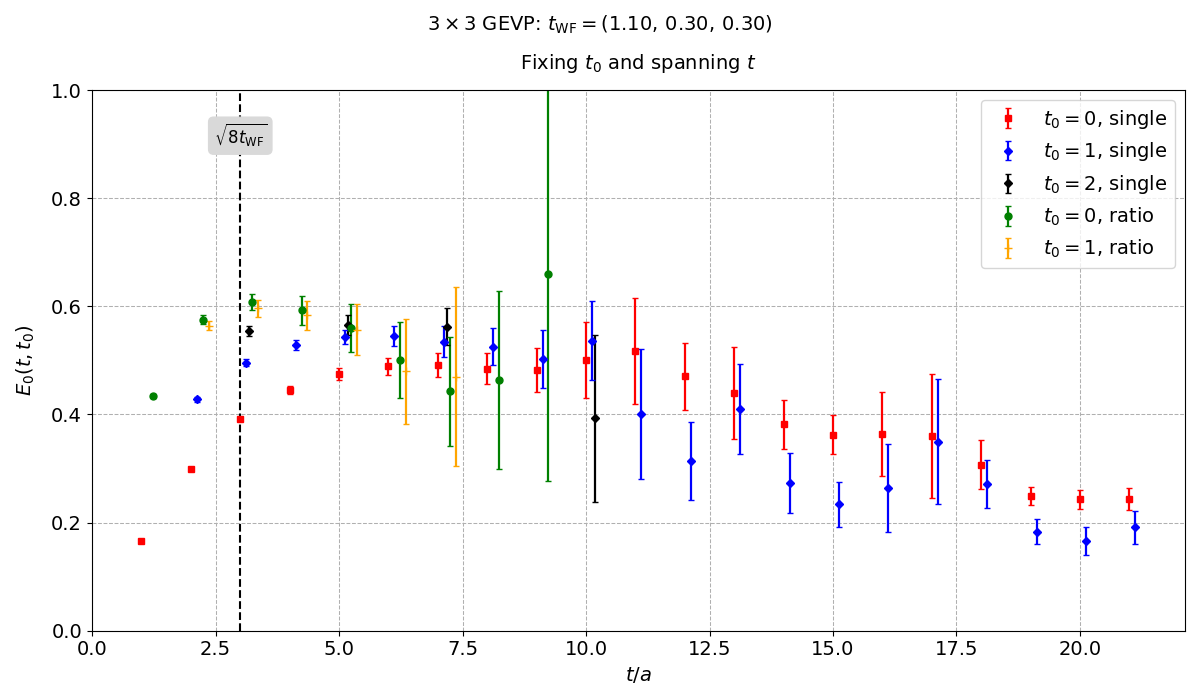

In [28]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 0.30, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)
t_t0_2s, Eg_t0_2s = GEVP_pyobs.GEVP(C, t0=2, const=1, case=case1)   # no signal for t0 = 3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()
Eg_2s, dEg_2s = Eg_t0_2s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_2s+0.18, Eg_2s, yerr=dEg_2s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 2$, {case1}', color='black', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"                 :  t0 = 2,  E_0 = {Eg_t0_2s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

(t,t0)=(5,4)  :  Array containing Infs or NaNs.

(t,t0)=(6,5)  :  Array containing Infs or NaNs.

(t,t0)=(8,7)  :  Array containing Infs or NaNs.

(t,t0)=(9,8)  :  Array containing Infs or NaNs.

(t,t0)=(10,9)  :  Array containing Infs or NaNs.

(t,t0)=(11,10)  :  Array containing Infs or NaNs.

(t,t0)=(12,11)  :  Array containing Infs or NaNs.

(t,t0)=(13,12)  :  Array containing Infs or NaNs.

(t,t0)=(4,2)  :  Array containing Infs or NaNs.

(t,t0)=(6,4)  :  Array containing Infs or NaNs.

(t,t0)=(7,5)  :  Array containing Infs or NaNs.

---- Result for 3x3 GEVP; Fixing t - t0 = const: ----

const = 1  :  E_0 = 0.1655(12)	0.4278(41)	0.5538(91)	0.569(24)	0.489(73)

const = 2  :  E_0 = 0.2999(26)	0.4960(63)	0.542(58)



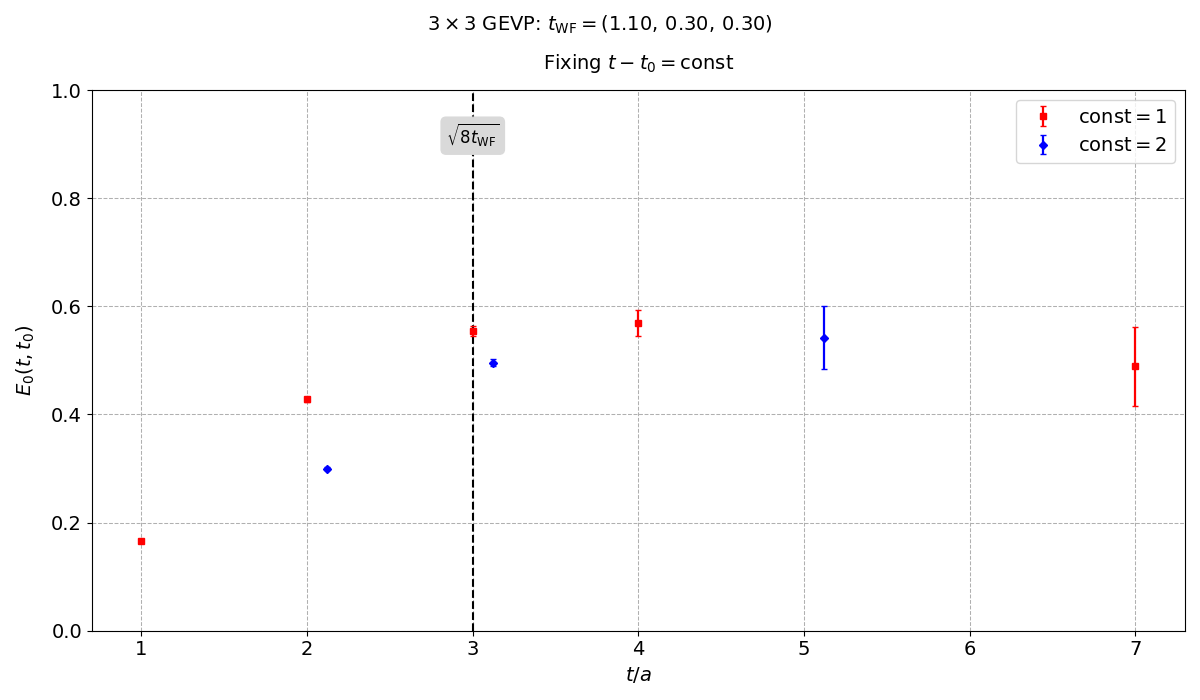

In [29]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 0.30, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
t_t0_c1, Eg_t0_c1 = GEVP_pyobs.GEVP(C, t0=-1, const=1)
t_t0_c2, Eg_t0_c2 = GEVP_pyobs.GEVP(C, t0=-1, const=2)  # no signal for const = 3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_c1, dEg_c1 = Eg_t0_c1.error()
Eg_c2, dEg_c2 = Eg_t0_c2.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t - t_0 = \mathrm{{const}}$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_c1[:,0], Eg_c1, yerr=dEg_c1, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 1$', color='red',  linewidth=1.6)
ax.errorbar(t_t0_c2[:,0]+0.12, Eg_c2, yerr=dEg_c2, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 2$', color='blue', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t - t0 = const: ----\n")
print(f"const = 1  :  E_0 = {Eg_t0_c1}")
print(f"const = 2  :  E_0 = {Eg_t0_c2}")

---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----

case = 'single'  :  t0 = 0,  E_0 = 0.1655(12)	0.2999(26)	0.3918(45)	0.4458(71)	0.475(11)	0.489(16)	0.491(22)	0.485(30)	0.483(41)	0.500(71)	0.53(15)	0.51(18)	0.413(74)	0.345(36)	0.316(31)	0.316(44)	0.319(61)	0.294(41)	0.259(24)	0.250(26)	0.241(21)	0.233(29)	0.222(29)	0.223(37)	0.207(21)	0.208(30)	0.210(37)	0.207(46)	0.209(49)	0.201(41)

                 :  t0 = 1,  E_0 = 0.4278(41)	0.4961(63)	0.5294(92)	0.543(13)	0.546(19)	0.541(26)	0.528(34)	0.519(47)	0.535(90)	0.57(16)	0.53(19)	0.419(78)	0.341(38)	0.311(32)	0.318(45)	0.322(65)	0.275(39)	0.231(23)	0.224(23)	0.208(21)	0.225(29)	0.215(30)	0.214(38)	0.184(21)	0.194(29)	0.198(36)	0.201(43)	0.196(48)	0.185(41)

                 :  t0 = 2,  E_0 = 0.5537(91)	0.567(13)	0.566(19)	0.560(29)	0.558(34)	0.543(41)	0.48(11)	0.40(10)	0.57(18)	0.52(22)	0.35(15)	0.274(46)	0.243(39)	0.278(56)	0.298(73)	0.209(52)	0.161(29)	0.156(30)	0.135(22)	0.171(34)	0.166(35)	0.156(50)	0.124(24)	0.146(36)	0.156(

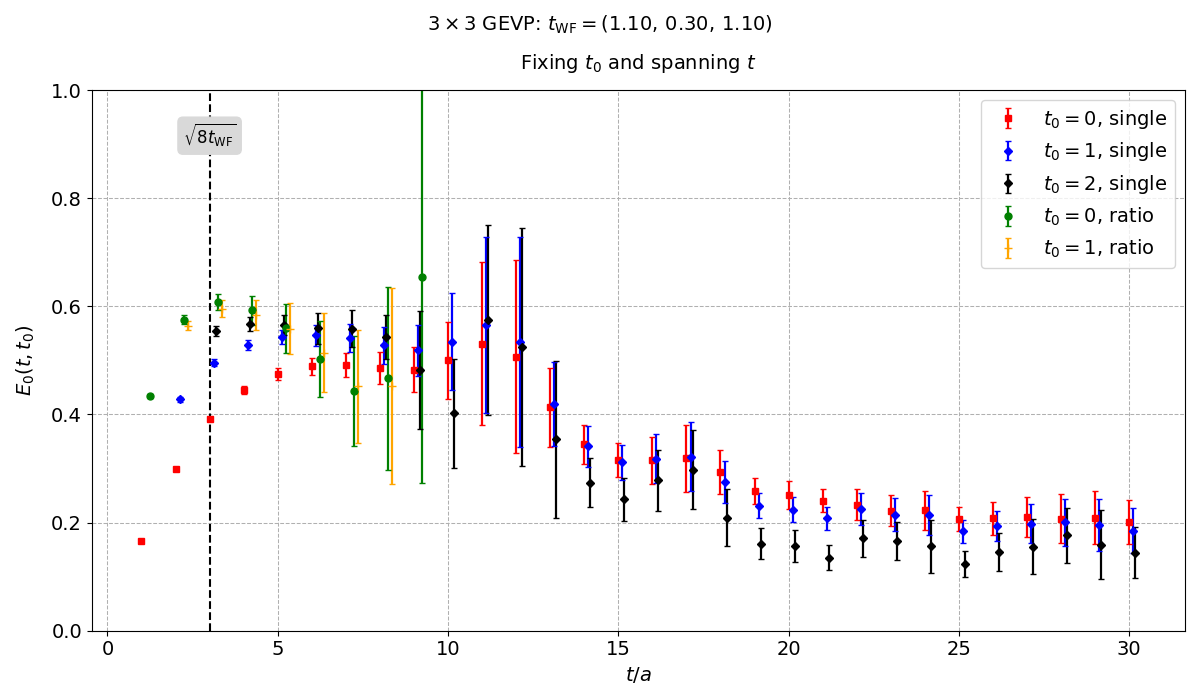

In [30]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 0.30, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   
t_t0_2s, Eg_t0_2s = GEVP_pyobs.GEVP(C, t0=2, const=1, case=case1)   # no signal for t0 = 3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()
Eg_2s, dEg_2s = Eg_t0_2s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_2s+0.18, Eg_2s, yerr=dEg_2s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 2$, {case1}', color='black', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"                 :  t0 = 2,  E_0 = {Eg_t0_2s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)


---- Result for 3x3 GEVP; Fixing t - t0 = const: ----

const = 1  :  E_0 = 0.1655(12)	0.4278(41)	0.5537(91)

const = 2  :  E_0 = 0.2999(26)	0.4961(63)	0.567(13)



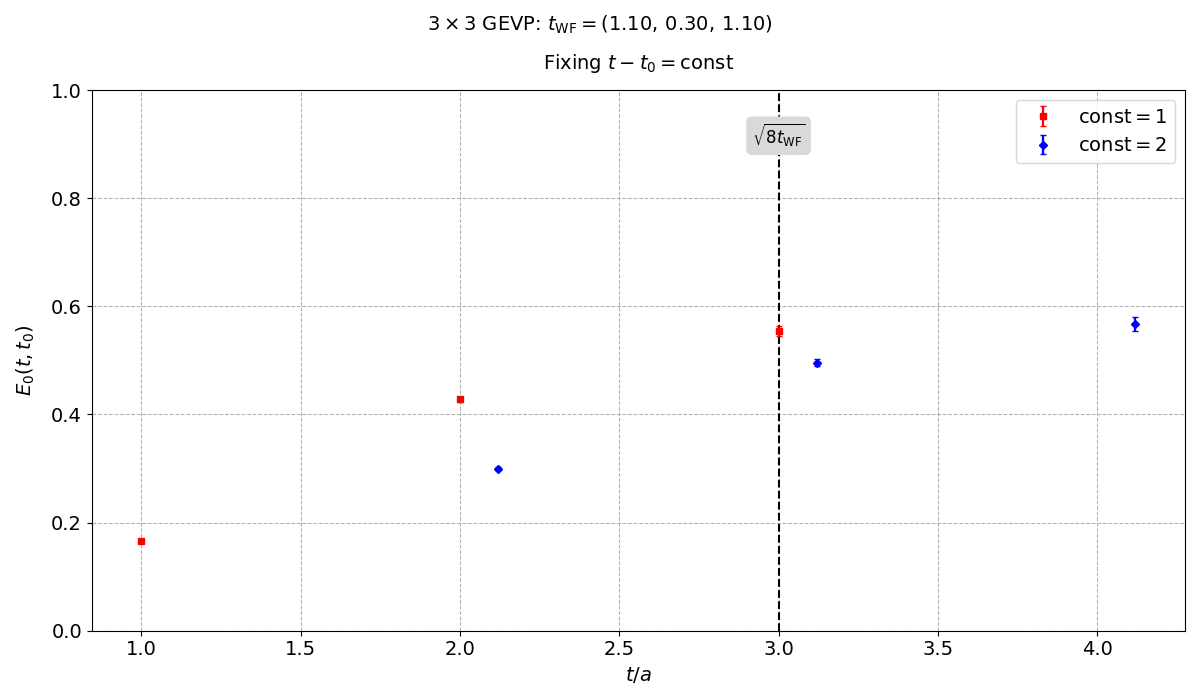

In [31]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 0.30, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
t_t0_c1, Eg_t0_c1 = GEVP_pyobs.GEVP(C, t0=-1, const=1)
t_t0_c2, Eg_t0_c2 = GEVP_pyobs.GEVP(C, t0=-1, const=2)  # no signal for const = 3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_c1, dEg_c1 = Eg_t0_c1.error()
Eg_c2, dEg_c2 = Eg_t0_c2.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t - t_0 = \mathrm{{const}}$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_c1[:,0], Eg_c1, yerr=dEg_c1, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 1$', color='red',  linewidth=1.6)
ax.errorbar(t_t0_c2[:,0]+0.12, Eg_c2, yerr=dEg_c2, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 2$', color='blue', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t - t0 = const: ----\n")
print(f"const = 1  :  E_0 = {Eg_t0_c1}")
print(f"const = 2  :  E_0 = {Eg_t0_c2}")

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/core/gradient.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  self.grad[:, i] = numpy.reshape(g(numpy.reshape(dx, x0.shape)), self.Na)


(t,t0)=(2,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(3,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(4,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(5,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(6,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(7,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(8,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(10,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(12,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(14,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(15,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(16,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(18,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(19,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(22,1)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(24,1)  :  StN problem, array containing Infs or NaNs.


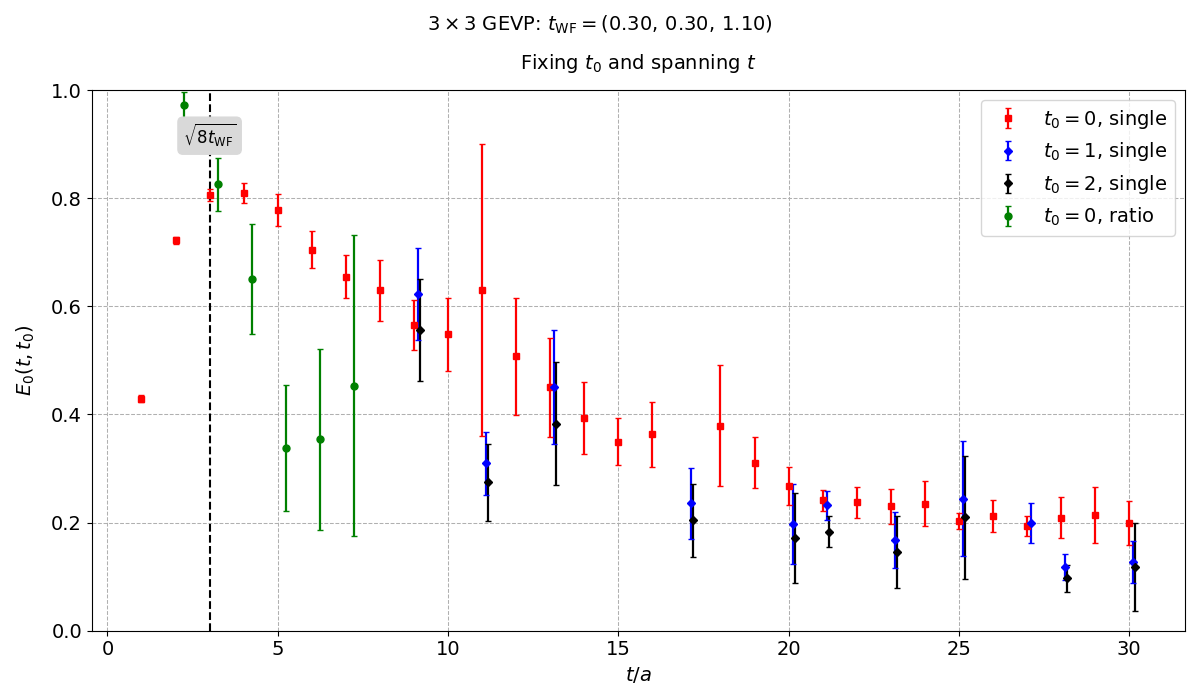

In [32]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 0.30, 0.30, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   
t_t0_2s, Eg_t0_2s = GEVP_pyobs.GEVP(C, t0=2, const=1, case=case1)   # no signal for t0 = 3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)   # no signal for t0 = 1, 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()
Eg_2s, dEg_2s = Eg_t0_2s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_2s+0.18, Eg_2s, yerr=dEg_2s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 2$, {case1}', color='black', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"                 :  t0 = 2,  E_0 = {Eg_t0_2s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)
/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/core/gradient.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  self.grad[:, i] = numpy.reshape(g(numpy.reshape(dx, x0.shape)), self.Na)


(t,t0)=(2,1)  :  Array containing Infs or NaNs.

(t,t0)=(3,2)  :  Array containing Infs or NaNs.

(t,t0)=(4,3)  :  Array containing Infs or NaNs.

(t,t0)=(3,1)  :  Array containing Infs or NaNs.

(t,t0)=(4,2)  :  Array containing Infs or NaNs.

---- Result for 3x3 GEVP; Fixing t - t0 = const: ----

const = 1  :  E_0 = 0.4293(66)

const = 2  :  E_0 = 0.7219(59)



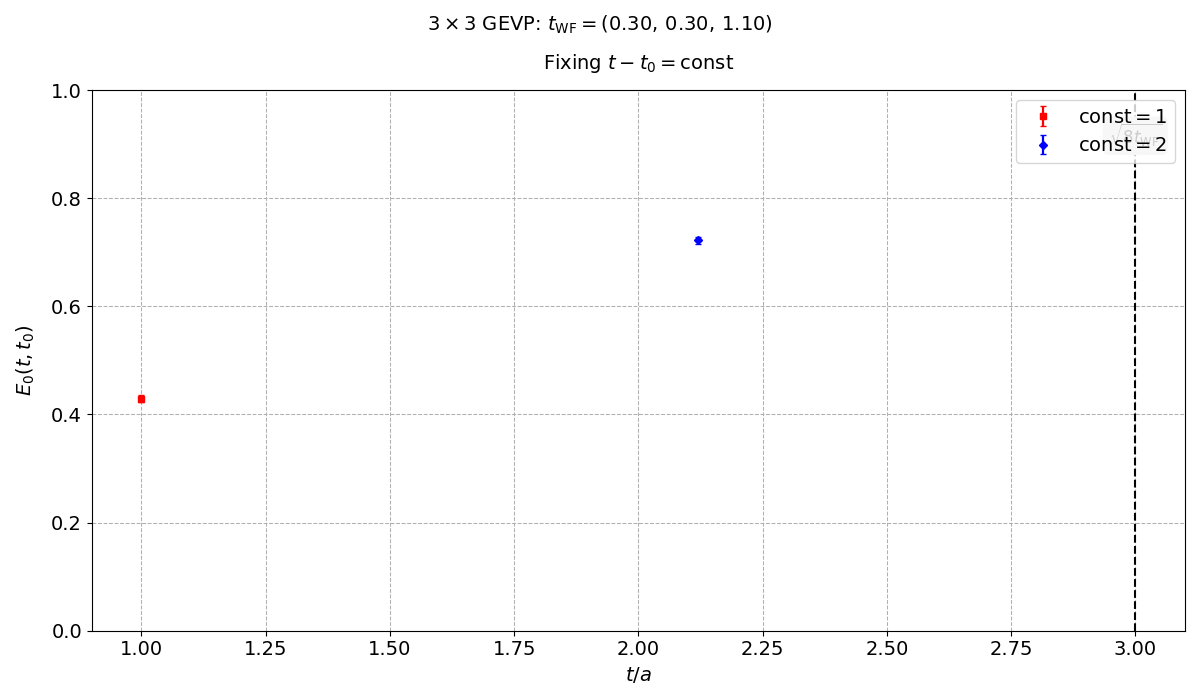

In [35]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 0.30, 0.30, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
t_t0_c1, Eg_t0_c1 = GEVP_pyobs.GEVP(C, t0=-1, const=1)
t_t0_c2, Eg_t0_c2 = GEVP_pyobs.GEVP(C, t0=-1, const=2)  # no signal for const = 3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_c1, dEg_c1 = Eg_t0_c1.error()
Eg_c2, dEg_c2 = Eg_t0_c2.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t - t_0 = \mathrm{{const}}$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_c1[:,0], Eg_c1, yerr=dEg_c1, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 1$', color='red',  linewidth=1.6)
ax.errorbar(t_t0_c2[:,0]+0.12, Eg_c2, yerr=dEg_c2, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 2$', color='blue', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t - t0 = const: ----\n")
print(f"const = 1  :  E_0 = {Eg_t0_c1}")
print(f"const = 2  :  E_0 = {Eg_t0_c2}")

(t,t0)=(4,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(8,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(9,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(10,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(13,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(14,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(16,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(17,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(18,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(19,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(20,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(21,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(23,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(25,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(28,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(29,2)  :  StN problem, array containing Infs or Na

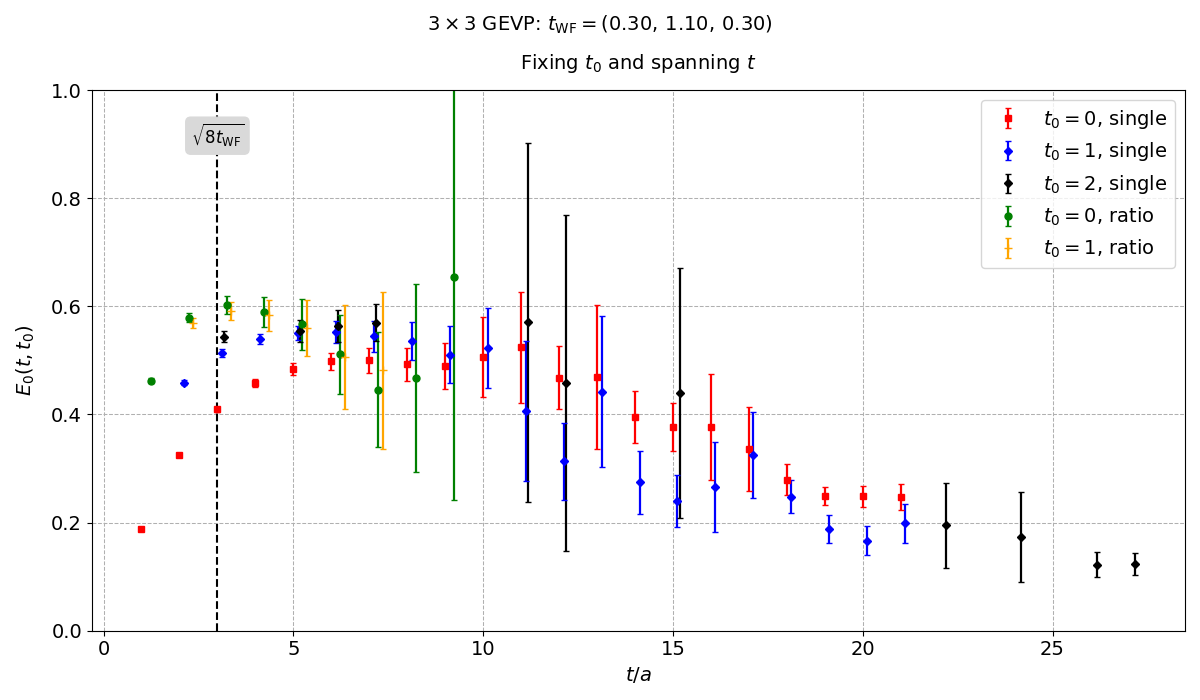

In [36]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 0.30, 1.10, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   
t_t0_2s, Eg_t0_2s = GEVP_pyobs.GEVP(C, t0=2, const=1, case=case1)   # no signal for t0 = 3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()
Eg_2s, dEg_2s = Eg_t0_2s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_2s+0.18, Eg_2s, yerr=dEg_2s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 2$, {case1}', color='black', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"                 :  t0 = 2,  E_0 = {Eg_t0_2s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)
/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/core/gradient.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  self.grad[:, i] = numpy.reshape(g(numpy.reshape(dx, x0.shape)), self.Na)


(t,t0)=(5,4)  :  Array containing Infs or NaNs.

(t,t0)=(4,2)  :  Array containing Infs or NaNs.

---- Result for 3x3 GEVP; Fixing t - t0 = const: ----

const = 1  :  E_0 = 0.1874(13)	0.4589(44)	0.5436(100)	0.534(36)

const = 2  :  E_0 = 0.3249(28)	0.5137(67)	0.526(62)



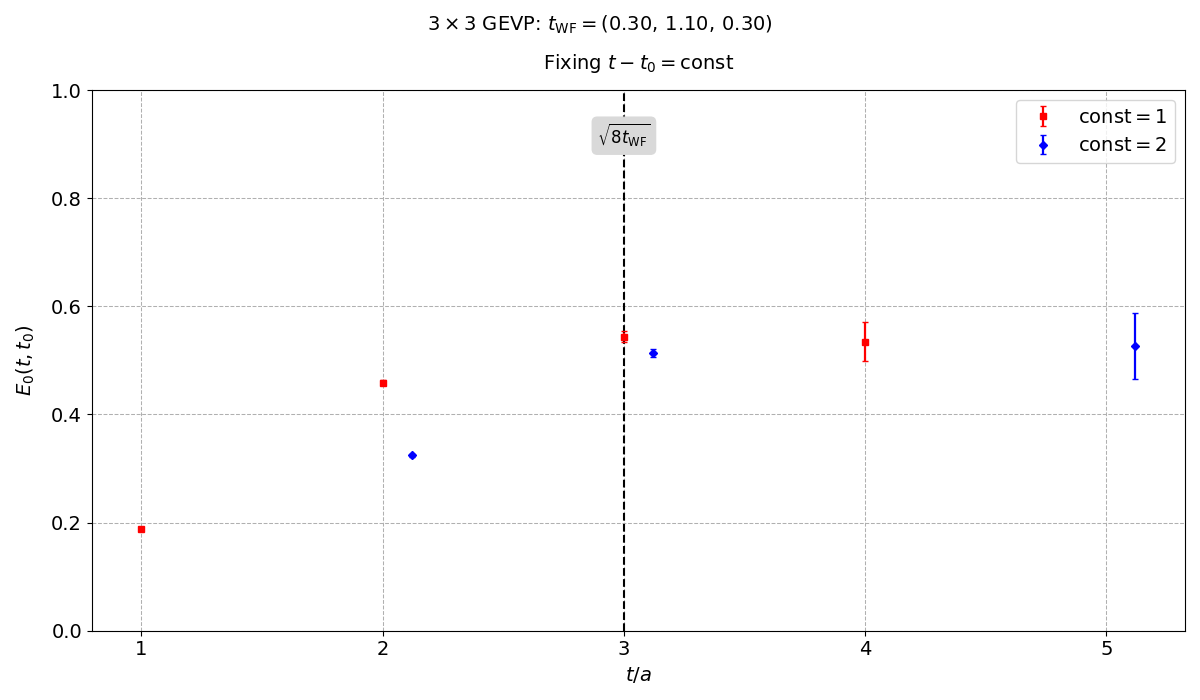

In [37]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 0.30, 1.10, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
t_t0_c1, Eg_t0_c1 = GEVP_pyobs.GEVP(C, t0=-1, const=1)
t_t0_c2, Eg_t0_c2 = GEVP_pyobs.GEVP(C, t0=-1, const=2)  # no signal for const = 3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_c1, dEg_c1 = Eg_t0_c1.error()
Eg_c2, dEg_c2 = Eg_t0_c2.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t - t_0 = \mathrm{{const}}$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_c1[:,0], Eg_c1, yerr=dEg_c1, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 1$', color='red',  linewidth=1.6)
ax.errorbar(t_t0_c2[:,0]+0.12, Eg_c2, yerr=dEg_c2, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 2$', color='blue', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t - t0 = const: ----\n")
print(f"const = 1  :  E_0 = {Eg_t0_c1}")
print(f"const = 2  :  E_0 = {Eg_t0_c2}")

---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----

case = 'single'  :  t0 = 0,  E_0 = 0.1874(13)	0.3249(28)	0.4097(48)	0.4579(73)	0.484(11)	0.498(16)	0.500(23)	0.493(31)	0.490(43)	0.502(69)	0.54(17)	0.51(17)	0.413(69)	0.356(42)	0.332(39)	0.322(48)	0.296(39)	0.267(26)	0.257(23)	0.259(25)	0.242(25)	0.235(28)	0.225(30)	0.227(40)	0.224(42)	0.211(36)	0.201(29)	0.204(40)	0.215(61)	0.203(47)

                 :  t0 = 1,  E_0 = 0.4589(44)	0.5138(66)	0.5398(95)	0.551(14)	0.555(19)	0.550(27)	0.536(35)	0.525(49)	0.515(66)	0.57(19)	0.53(16)	0.422(74)	0.355(45)	0.329(42)	0.323(50)	0.293(40)	0.256(26)	0.240(23)	0.236(27)	0.229(25)	0.227(29)	0.217(32)	0.220(41)	0.216(42)	0.205(34)	0.193(28)	0.199(38)	0.208(60)	0.193(48)

                 :  t0 = 2,  E_0 = 0.543(10)	0.552(14)	0.554(20)	0.562(29)	0.566(33)	0.549(41)	0.483(96)	0.388(80)	0.54(36)	0.43(21)	0.376(90)	0.289(54)	0.263(50)	0.279(64)	0.248(50)	0.190(33)	0.163(29)	0.154(29)	0.158(29)	0.173(33)	0.167(36)	0.165(51)	0.167(53)	0.165(45)	0.14

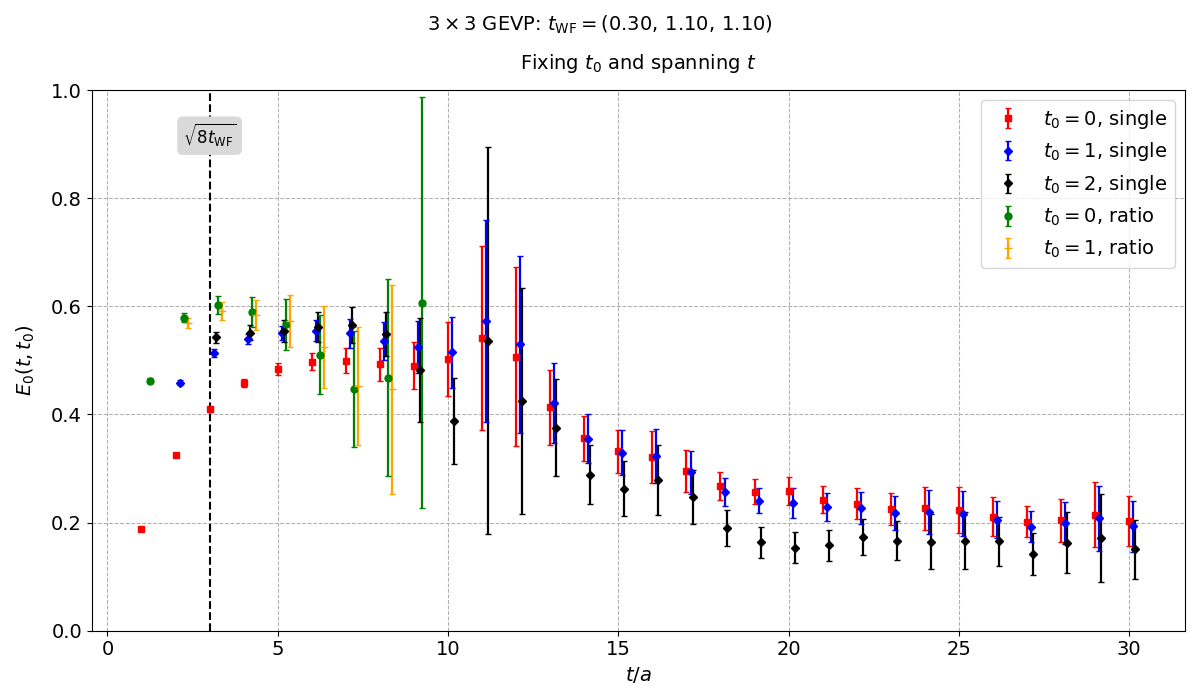

In [38]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 0.30, 1.10, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   
t_t0_2s, Eg_t0_2s = GEVP_pyobs.GEVP(C, t0=2, const=1, case=case1)   # no signal for t0 = 3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()
Eg_2s, dEg_2s = Eg_t0_2s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_2s+0.18, Eg_2s, yerr=dEg_2s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 2$, {case1}', color='black', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"                 :  t0 = 2,  E_0 = {Eg_t0_2s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)


---- Result for 3x3 GEVP; Fixing t - t0 = const: ----

const = 1  :  E_0 = 0.1874(13)	0.4589(44)	0.543(10)

const = 2  :  E_0 = 0.3249(28)	0.5138(66)	0.552(14)



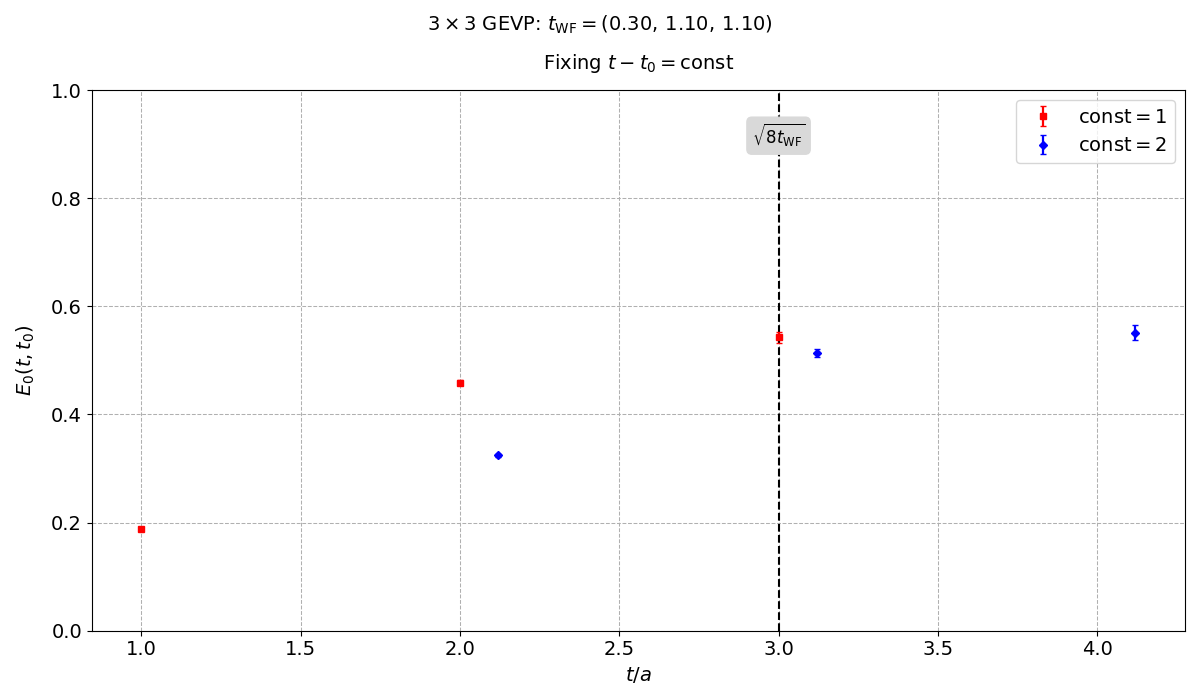

In [39]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 0.30, 1.10, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
t_t0_c1, Eg_t0_c1 = GEVP_pyobs.GEVP(C, t0=-1, const=1)
t_t0_c2, Eg_t0_c2 = GEVP_pyobs.GEVP(C, t0=-1, const=2)  # no signal for const = 3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_c1, dEg_c1 = Eg_t0_c1.error()
Eg_c2, dEg_c2 = Eg_t0_c2.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t - t_0 = \mathrm{{const}}$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_c1[:,0], Eg_c1, yerr=dEg_c1, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 1$', color='red',  linewidth=1.6)
ax.errorbar(t_t0_c2[:,0]+0.12, Eg_c2, yerr=dEg_c2, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 2$', color='blue', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t - t0 = const: ----\n")
print(f"const = 1  :  E_0 = {Eg_t0_c1}")
print(f"const = 2  :  E_0 = {Eg_t0_c2}")

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/core/gradient.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  self.grad[:, i] = numpy.reshape(g(numpy.reshape(dx, x0.shape)), self.Na)


(t,t0)=(10,2)  :  StN problem, array containing Infs or NaNs.

(t,t0)=(11,2)  :  StN problem, array containing Infs or NaNs.



/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----

case = 'single'  :  t0 = 0,  E_0 = 0.1672(12)	0.3062(26)	0.4019(45)	0.4578(72)	0.487(11)	0.498(16)	0.498(22)	0.490(30)	0.486(41)	0.498(68)	0.52(11)	0.469(62)	0.47(13)	0.396(52)	0.324(21)	0.339(37)	0.352(91)	0.325(64)	0.277(28)	0.253(20)	0.245(22)	0.249(31)	0.234(25)	0.277(77)	nan(18)	0.218(30)	0.218(34)	0.206(32)	0.196(25)	0.198(27)

                 :  t0 = 1,  E_0 = 0.4452(41)	0.5192(63)	0.5542(92)	0.565(13)	0.561(20)	0.548(28)	0.536(34)	0.523(45)	0.531(74)	0.40(12)	0.314(72)	0.43(14)	0.279(63)	0.210(27)	0.246(49)	0.335(95)	0.299(69)	0.203(41)	0.167(27)	0.181(28)	0.201(33)	0.141(27)	0.197(84)	nan(20)	0.175(33)	0.173(37)	0.160(37)	0.136(36)	0.154(36)

                 :  t0 = 2,  E_0 = 0.180(11)	0.555(30)	0.623(25)	0.604(26)	0.578(31)	0.552(39)	0.549(75)

case = 'ratio'   :  t0 = 0,  E_0 = 0.4452(41)	0.5934(86)	0.625(16)	0.602(28)	0.557(46)	0.493(70)	0.44(10)	0.46(16)	0.60(35)

                 :  t0 = 1,  E_0 = 0.5933(86)	0.62

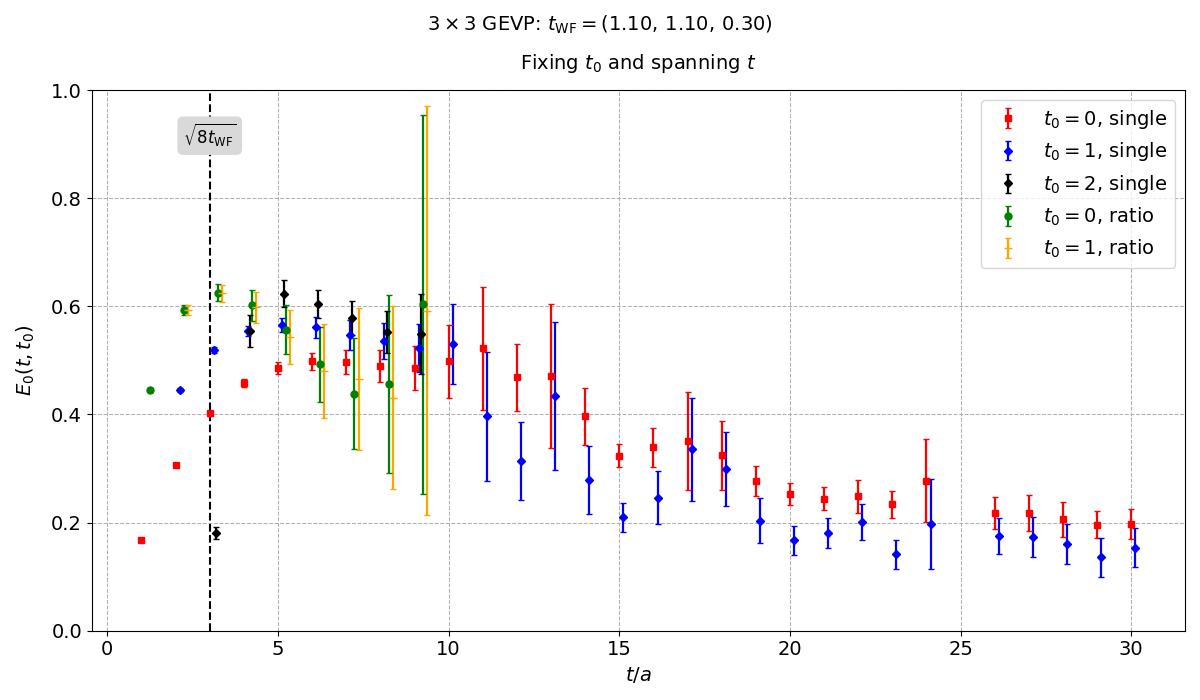

In [40]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 1.10, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   
t_t0_2s, Eg_t0_2s = GEVP_pyobs.GEVP(C, t0=2, const=1, case=case1)   # no signal for t0 = 3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()
Eg_2s, dEg_2s = Eg_t0_2s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_2s+0.18, Eg_2s, yerr=dEg_2s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 2$, {case1}', color='black', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t0 and spanning t: ----\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"                 :  t0 = 2,  E_0 = {Eg_t0_2s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)
/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/core/gradient.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  self.grad[:, i] = numpy.reshape(g(numpy.reshape(dx, x0.shape)), self.Na)


(t,t0)=(6,4)  :  Array containing Infs or NaNs.

---- Result for 3x3 GEVP; Fixing t - t0 = const: ----

const = 1  :  E_0 = 0.1672(12)	0.4452(41)	0.180(11)	0.632(17)	0.598(30)	0.574(59)

const = 2  :  E_0 = 0.3062(26)	0.5192(63)	0.555(30)	0.614(23)	0.530(59)	0.43(22)	0.42(20)



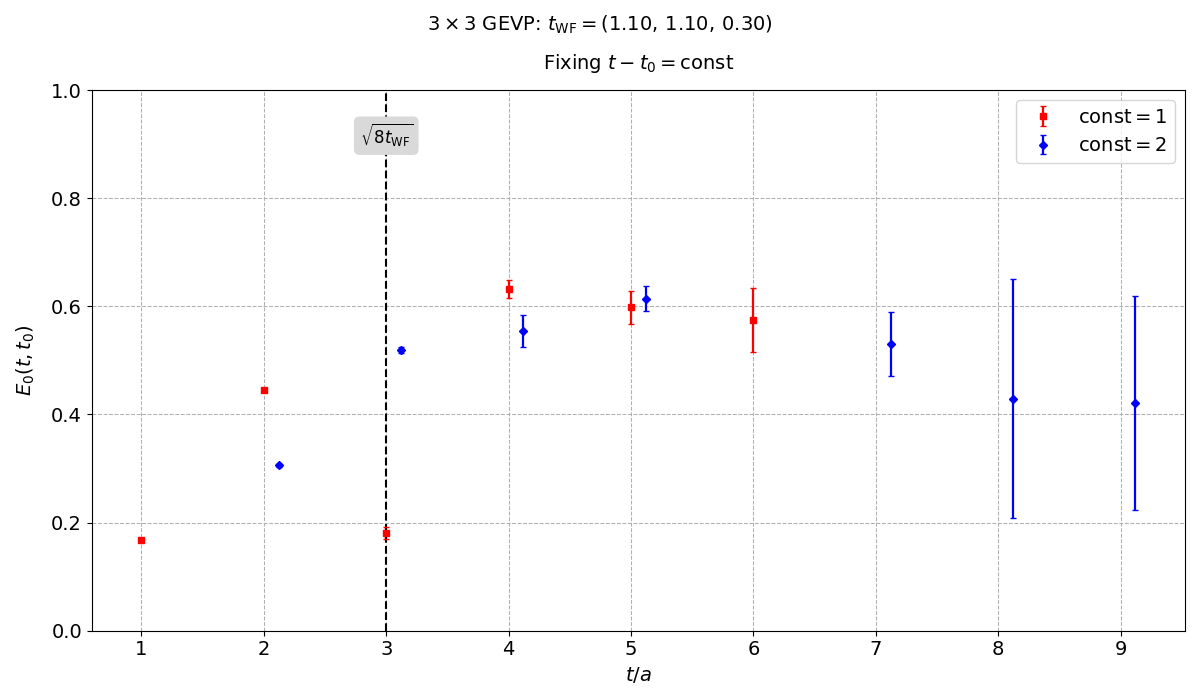

In [45]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 1.10, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
t_t0_c1, Eg_t0_c1 = GEVP_pyobs.GEVP(C, t0=-1, const=1)
t_t0_c2, Eg_t0_c2 = GEVP_pyobs.GEVP(C, t0=-1, const=2)  # no signal for const = 3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_c1, dEg_c1 = Eg_t0_c1.error()
Eg_c2, dEg_c2 = Eg_t0_c2.error()

fig, ax = plt.subplots(figsize=(12, 7))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP: $t_\mathrm{{WF}}=({tW0:.2f}, \, {tW1:.2f}, \, {tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t - t_0 = \mathrm{{const}}$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_c1[:,0], Eg_c1, yerr=dEg_c1, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 1$', color='red',  linewidth=1.6)
ax.errorbar(t_t0_c2[:,0]+0.12, Eg_c2, yerr=dEg_c2, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$\mathrm{{const}} = 2$', color='blue', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$\sqrt{{8 t_\mathrm{{WF}}}}$", (tmin012, ymax-0.1*ymax), xytext=(tmin012, ymax-0.1*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"---- Result for 3x3 GEVP; Fixing t - t0 = const: ----\n")
print(f"const = 1  :  E_0 = {Eg_t0_c1}")
print(f"const = 2  :  E_0 = {Eg_t0_c2}")